In [1]:
%load_ext pretty_jupyter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [5]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [7]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [8]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [9]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [10]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [11]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [12]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def select_clusters_below_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] < cutoff].tolist()

    return select_cl

In [13]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Markers for dotplots

In [14]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [15]:
class_markers = [
    'CD4',
    'CD8A',
    'CD27',
    'GZMB',
    'GZMK',
    'IFI44L',
    'KLRF1',
    'SOX4'
]

## Read previous, non-tracked labels
We ran a preliminary analysis of our dataset that wasn't tracked for reproducibility. Here, we'll retrieve the labels for visualization and comparison to check for consistency.

In [16]:
original_uuid = '3868592c-0087-4ed8-98b2-4bf1b8676111'
original_df = read_parquet_uuid(original_uuid)
original_df = original_df[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
original_df = original_df.rename({'AIFI_L1': 'original_L1', 'AIFI_L2': 'original_L2', 'AIFI_L3': 'original_L3'}, axis = 1)

In [17]:
original_df.head()

barcodes original_L1 original_L2 original_L3
0  05ea9806794211eb93b836d1cb6129eb          DC        cDC1        cDC1
1  e225c914794011eb9282e2ceeb91ba52          DC        cDC1        cDC1
2  b1379eae795411eb958b0245821e6993          DC        cDC1        cDC1
3  b13d3a8a795411eb958b0245821e6993          DC        cDC1        cDC1
4  b1430d16795411eb958b0245821e6993          DC        cDC1        cDC1

## Read cell type hierarchy

In [18]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [19]:
search_id = 'fermium-chromium-gallium'

Retrieve files stored in our HISE project store

In [20]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [21]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [22]:
search_df['AIFI_L3'].tolist()

['CD8 reasons',
 'CD8aa',
 'CM CD8 T cell',
 'Core naive CD8 T cell',
 'GZMK- CD27+ EM CD8 T cell',
 'GZMK+ CD27+ EM CD8 T cell',
 'ISG+ memory CD8 T cell',
 'ISG+ naive CD8 T cell',
 'KLRF1- GZMB+ CD27- EM CD8 T cell',
 'KLRF1+ GZMB+ CD27- EM CD8 T cell',
 'SOX4+ naive CD8 T cell']

## Review CD8aa

In [23]:
cell_type = 'CD8aa'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [24]:
type_uuid

'15b5ddc7-ec0d-4a45-ab0b-09b5c6c9680f'

In [25]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 15b5ddc7-ec0d-4a45-ab0b-09b5c6c9680f
Files have been successfully downloaded!


### Clustering

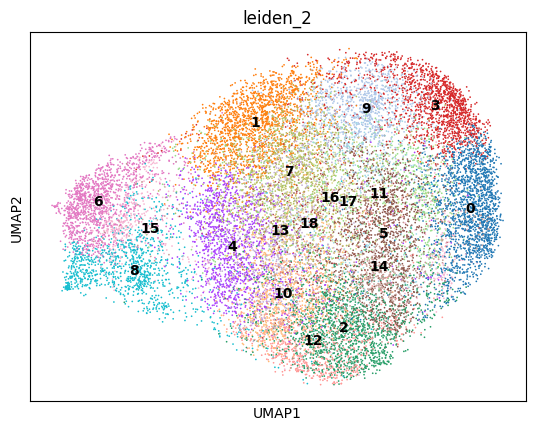

In [26]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

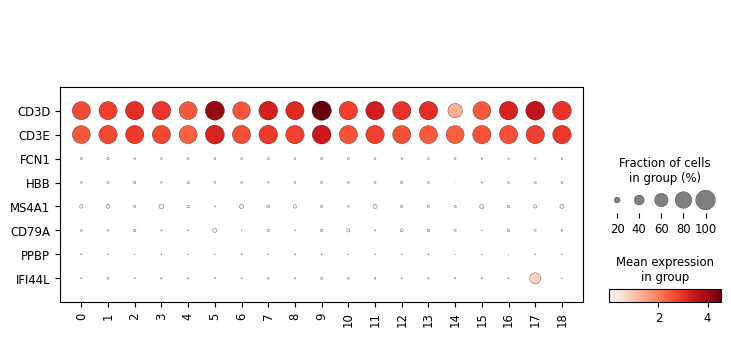

In [27]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

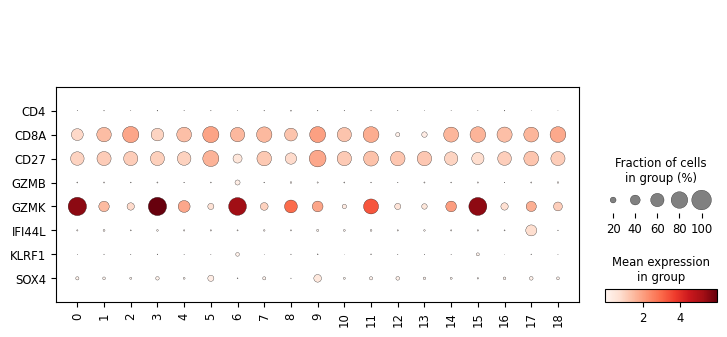

In [28]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [29]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1789
1     1704
2     1610
3     1541
4     1400
5     1313
6     1239
7     1163
8     1126
9     1051
10     993
11     931
12     813
13     763
14     590
15     583
16     442
17     407
18     406
Name: count, dtype: int64

### Comparison to original labels

In [30]:
adata = add_labels(adata, original_df)

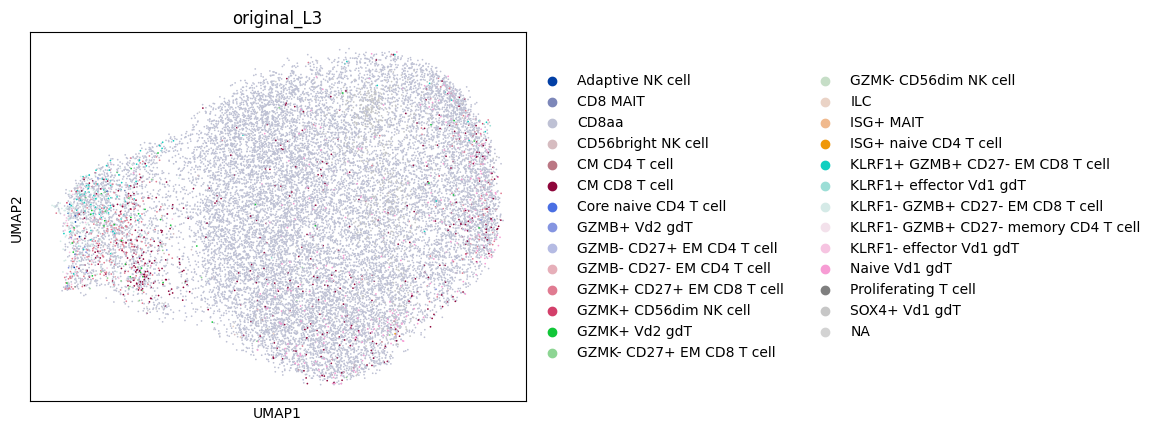

In [31]:
sc.pl.umap(adata, color = 'original_L3')

In [32]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CD8aa                                   17530
SOX4+ Vd1 gdT                             630
CM CD8 T cell                             473
GZMK+ CD27+ EM CD8 T cell                 336
Naive Vd1 gdT                             288
KLRF1- GZMB+ CD27- EM CD8 T cell          178
NaN                                       129
KLRF1+ GZMB+ CD27- EM CD8 T cell          104
KLRF1- effector Vd1 gdT                    42
GZMK+ Vd2 gdT                              41
GZMK- CD27+ EM CD8 T cell                  24
GZMB- CD27+ EM CD4 T cell                  17
CD56bright NK cell                         17
KLRF1+ effector Vd1 gdT                    11
GZMB+ Vd2 gdT                              10
Adaptive NK cell                            8
GZMK+ CD56dim NK cell                       6
ILC                                         4
KLRF1- GZMB+ CD27- memory CD4 T cell        4
CD8 MAIT                                    3
GZMB- CD27- EM CD4 T cell                   2
CM CD4 T cell         

In [33]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CD8aa                                   0.882501
SOX4+ Vd1 gdT                           0.031716
CM CD8 T cell                           0.023812
GZMK+ CD27+ EM CD8 T cell               0.016915
Naive Vd1 gdT                           0.014499
KLRF1- GZMB+ CD27- EM CD8 T cell        0.008961
NaN                                     0.006494
KLRF1+ GZMB+ CD27- EM CD8 T cell        0.005236
KLRF1- effector Vd1 gdT                 0.002114
GZMK+ Vd2 gdT                           0.002064
GZMK- CD27+ EM CD8 T cell               0.001208
GZMB- CD27+ EM CD4 T cell               0.000856
CD56bright NK cell                      0.000856
KLRF1+ effector Vd1 gdT                 0.000554
GZMB+ Vd2 gdT                           0.000503
Adaptive NK cell                        0.000403
GZMK+ CD56dim NK cell                   0.000302
ILC                                     0.000201
KLRF1- GZMB+ CD27- memory CD4 T cell    0.000201
CD8 MAIT                                0.000151
GZMB- CD

## Review CM CD8 T cell

In [34]:
cell_type = 'CM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [35]:
type_uuid

'87ffaf58-d409-48bb-89a5-aec82f466175'

In [36]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 87ffaf58-d409-48bb-89a5-aec82f466175
Files have been successfully downloaded!


### Clustering

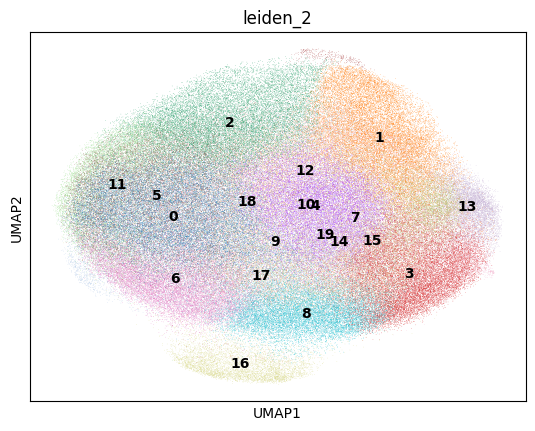

In [37]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

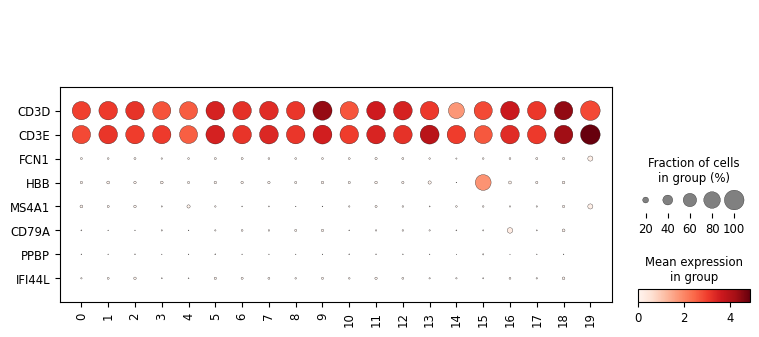

In [38]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

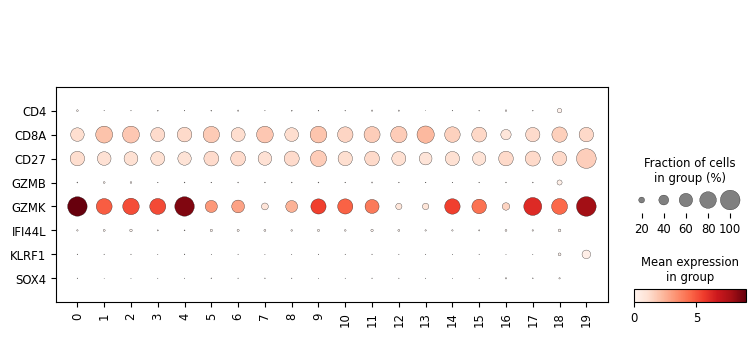

In [39]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [40]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     18882
1     18557
2     18298
3     18096
4     16738
5     15548
6     15503
7     14050
8     12703
9     10541
10    10313
11     9924
12     7573
13     7247
14     7141
15     6140
16     6017
17     4979
18     2356
19        6
Name: count, dtype: int64

### Comparison to original labels

In [41]:
adata = add_labels(adata, original_df)

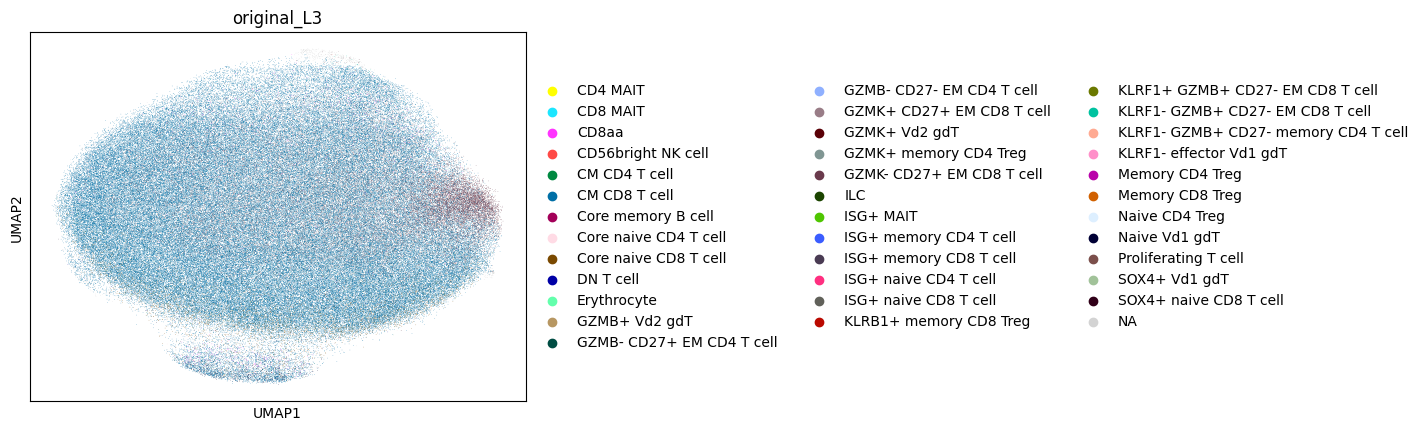

In [42]:
sc.pl.umap(adata, color = 'original_L3')

In [43]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CM CD8 T cell                           169741
GZMK- CD27+ EM CD8 T cell                17806
GZMK+ CD27+ EM CD8 T cell                15449
NaN                                       8334
Core naive CD8 T cell                     4514
GZMB- CD27+ EM CD4 T cell                 1759
Naive Vd1 gdT                              841
CD8aa                                      812
CM CD4 T cell                              493
Core naive CD4 T cell                      227
CD8 MAIT                                   131
KLRF1- GZMB+ CD27- EM CD8 T cell            90
DN T cell                                   85
GZMK+ Vd2 gdT                               81
ISG+ memory CD8 T cell                      62
Naive CD4 Treg                              44
Memory CD8 Treg                             33
GZMB- CD27- EM CD4 T cell                   21
SOX4+ Vd1 gdT                               20
SOX4+ naive CD8 T cell                      17
ISG+ naive CD8 T cell                       12
G

In [44]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CM CD8 T cell                           0.769410
GZMK- CD27+ EM CD8 T cell               0.080712
GZMK+ CD27+ EM CD8 T cell               0.070028
NaN                                     0.037777
Core naive CD8 T cell                   0.020461
GZMB- CD27+ EM CD4 T cell               0.007973
Naive Vd1 gdT                           0.003812
CD8aa                                   0.003681
CM CD4 T cell                           0.002235
Core naive CD4 T cell                   0.001029
CD8 MAIT                                0.000594
KLRF1- GZMB+ CD27- EM CD8 T cell        0.000408
DN T cell                               0.000385
GZMK+ Vd2 gdT                           0.000367
ISG+ memory CD8 T cell                  0.000281
Naive CD4 Treg                          0.000199
Memory CD8 Treg                         0.000150
GZMB- CD27- EM CD4 T cell               0.000095
SOX4+ Vd1 gdT                           0.000091
SOX4+ naive CD8 T cell                  0.000077
ISG+ nai

## Review Core naive CD8 T cell

In [45]:
cell_type = 'Core naive CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [46]:
type_uuid

'863f870d-8990-41c9-9d85-79334fd44a41'

In [47]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 863f870d-8990-41c9-9d85-79334fd44a41
Files have been successfully downloaded!


### Clustering

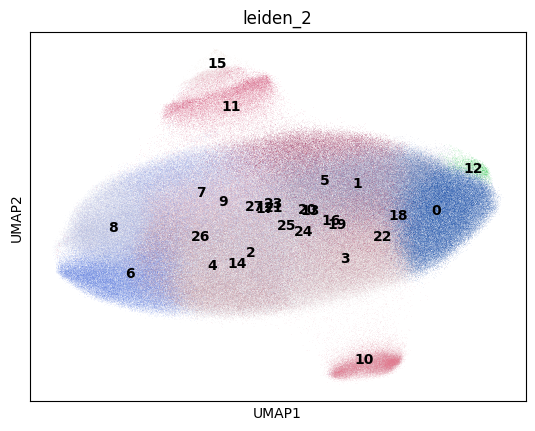

In [48]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

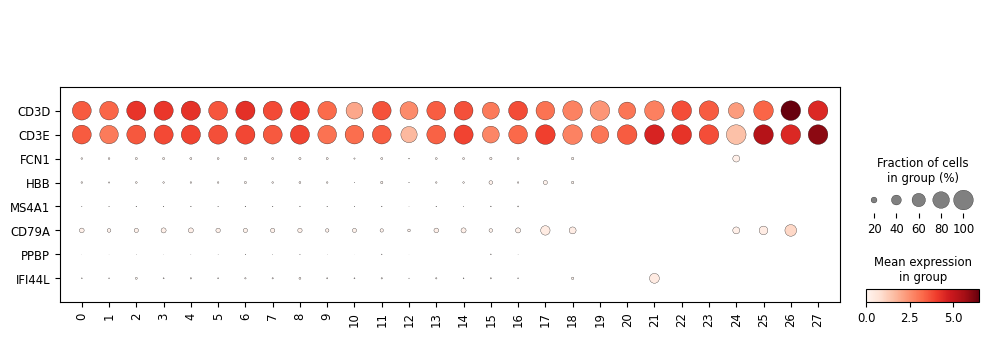

In [49]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

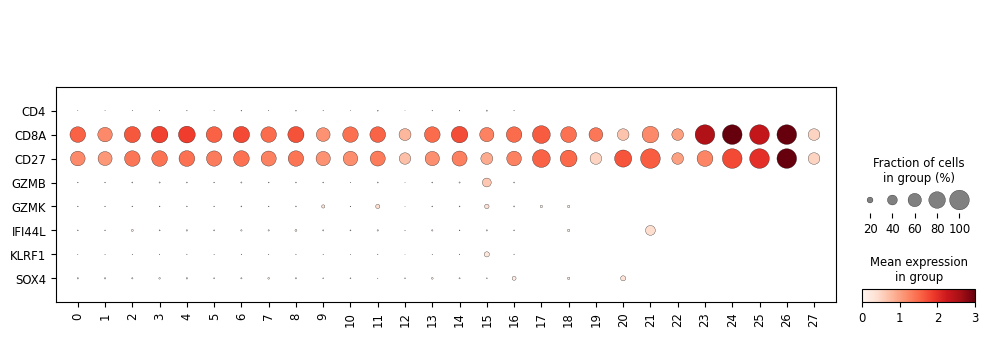

In [50]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [51]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     91608
1     81868
2     75011
3     70272
4     68107
5     64593
6     61968
7     61252
8     51604
9     50244
10    36408
11    29783
12     2832
13     1772
14     1417
15      678
16      580
17       16
18       16
19        8
20        6
21        5
22        4
23        4
24        4
25        3
26        2
27        2
Name: count, dtype: int64

### Comparison to original labels

In [52]:
adata = add_labels(adata, original_df)

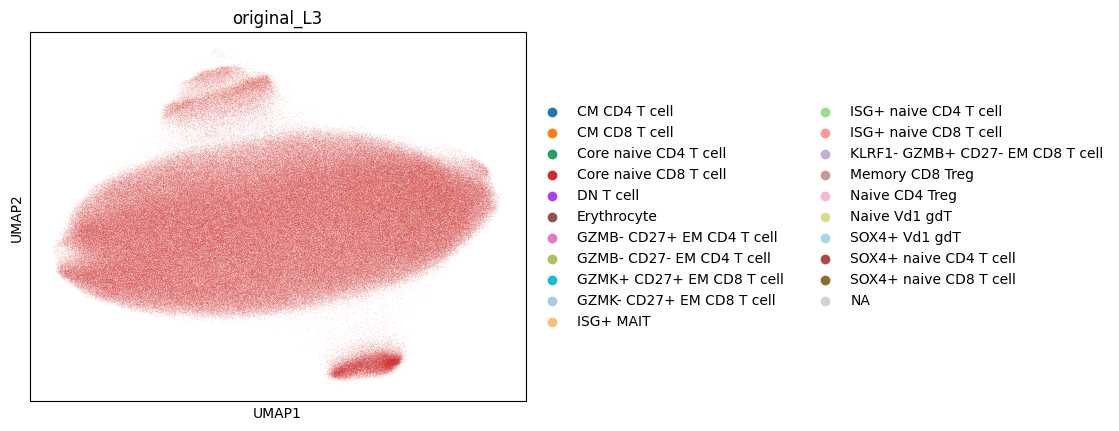

In [53]:
sc.pl.umap(adata, color = 'original_L3')

In [54]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Core naive CD8 T cell               730286
SOX4+ naive CD8 T cell                8357
NaN                                   7640
CM CD8 T cell                         1980
Core naive CD4 T cell                 1131
ISG+ naive CD8 T cell                  208
GZMK- CD27+ EM CD8 T cell              148
SOX4+ naive CD4 T cell                  72
DN T cell                               63
Naive Vd1 gdT                           62
Naive CD4 Treg                          33
CM CD4 T cell                           30
Memory CD8 Treg                         23
GZMK+ CD27+ EM CD8 T cell                8
ISG+ naive CD4 T cell                    7
Erythrocyte                              6
GZMB- CD27- EM CD4 T cell                5
SOX4+ Vd1 gdT                            5
KLRF1- GZMB+ CD27- EM CD8 T cell         1
GZMB- CD27+ EM CD4 T cell                1
ISG+ MAIT                                1
Name: count, dtype: int64

In [55]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Core naive CD8 T cell               0.973628
SOX4+ naive CD8 T cell              0.011142
NaN                                 0.010186
CM CD8 T cell                       0.002640
Core naive CD4 T cell               0.001508
ISG+ naive CD8 T cell               0.000277
GZMK- CD27+ EM CD8 T cell           0.000197
SOX4+ naive CD4 T cell              0.000096
DN T cell                           0.000084
Naive Vd1 gdT                       0.000083
Naive CD4 Treg                      0.000044
CM CD4 T cell                       0.000040
Memory CD8 Treg                     0.000031
GZMK+ CD27+ EM CD8 T cell           0.000011
ISG+ naive CD4 T cell               0.000009
Erythrocyte                         0.000008
GZMB- CD27- EM CD4 T cell           0.000007
SOX4+ Vd1 gdT                       0.000007
KLRF1- GZMB+ CD27- EM CD8 T cell    0.000001
GZMB- CD27+ EM CD4 T cell           0.000001
ISG+ MAIT                           0.000001
Name: count, dtype: float64

## Review GZMK- CD27+ EM CD8 T cell

In [56]:
cell_type = 'GZMK- CD27+ EM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [57]:
type_uuid

'b58d374d-5777-4104-a58c-d31136d1428f'

In [58]:
adata = read_adata_uuid(type_uuid)

downloading fileID: b58d374d-5777-4104-a58c-d31136d1428f
Files have been successfully downloaded!


### Clustering

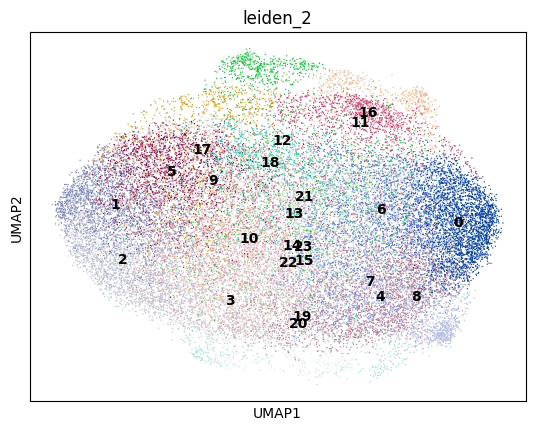

In [59]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

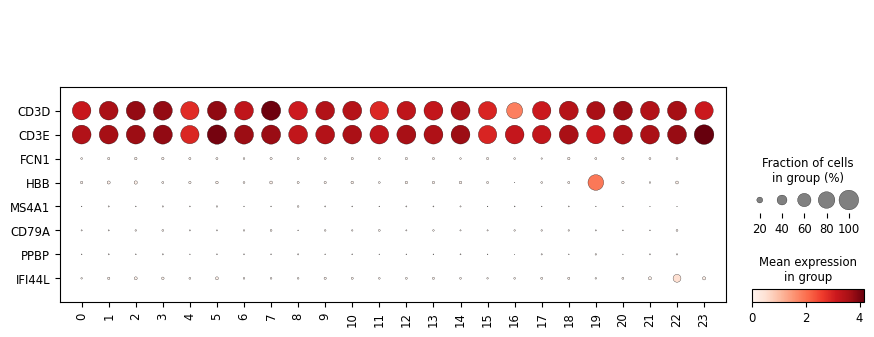

In [60]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

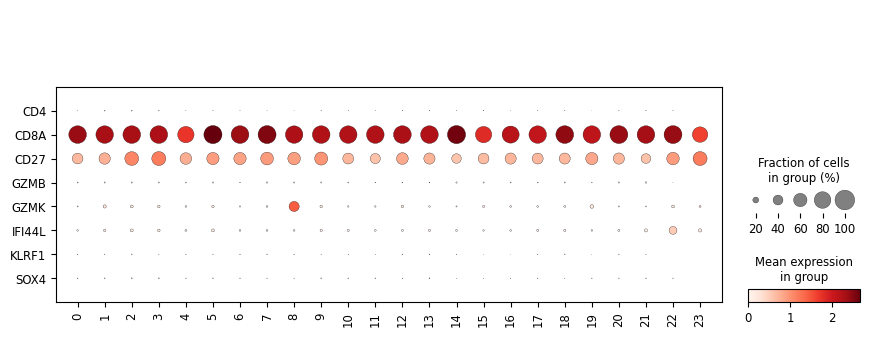

In [61]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [62]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     2999
1     2407
2     2379
3     2259
4     1943
5     1842
6     1802
7     1698
8     1576
9     1441
10    1435
11    1417
12    1392
13    1169
14    1082
15     965
16     956
17     899
18     872
19     677
20     673
21     574
22     291
23      22
Name: count, dtype: int64

### Comparison to original labels

In [63]:
adata = add_labels(adata, original_df)

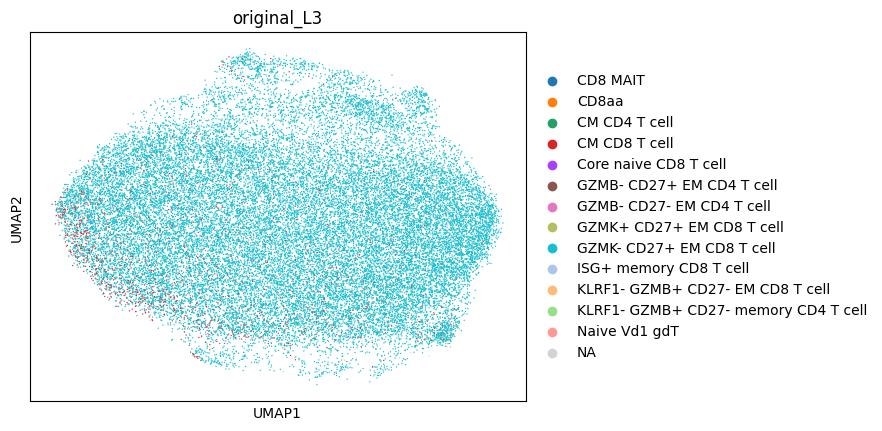

In [64]:
sc.pl.umap(adata, color = 'original_L3')

In [65]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
GZMK- CD27+ EM CD8 T cell               31188
CM CD8 T cell                            1123
NaN                                       306
GZMB- CD27+ EM CD4 T cell                  43
GZMK+ CD27+ EM CD8 T cell                  43
Core naive CD8 T cell                      33
GZMB- CD27- EM CD4 T cell                  13
KLRF1- GZMB+ CD27- EM CD8 T cell            6
CD8aa                                       4
CM CD4 T cell                               4
CD8 MAIT                                    3
ISG+ memory CD8 T cell                      2
KLRF1- GZMB+ CD27- memory CD4 T cell        1
Naive Vd1 gdT                               1
Name: count, dtype: int64

In [66]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
GZMK- CD27+ EM CD8 T cell               0.951724
CM CD8 T cell                           0.034269
NaN                                     0.009338
GZMB- CD27+ EM CD4 T cell               0.001312
GZMK+ CD27+ EM CD8 T cell               0.001312
Core naive CD8 T cell                   0.001007
GZMB- CD27- EM CD4 T cell               0.000397
KLRF1- GZMB+ CD27- EM CD8 T cell        0.000183
CD8aa                                   0.000122
CM CD4 T cell                           0.000122
CD8 MAIT                                0.000092
ISG+ memory CD8 T cell                  0.000061
KLRF1- GZMB+ CD27- memory CD4 T cell    0.000031
Naive Vd1 gdT                           0.000031
Name: count, dtype: float64

## Review GZMK+ CD27+ EM CD8 T cell

In [67]:
cell_type = 'GZMK+ CD27+ EM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [68]:
type_uuid

'aed11773-f439-40f7-a3bd-84e55d67b676'

In [69]:
adata = read_adata_uuid(type_uuid)

downloading fileID: aed11773-f439-40f7-a3bd-84e55d67b676
Files have been successfully downloaded!


### Clustering

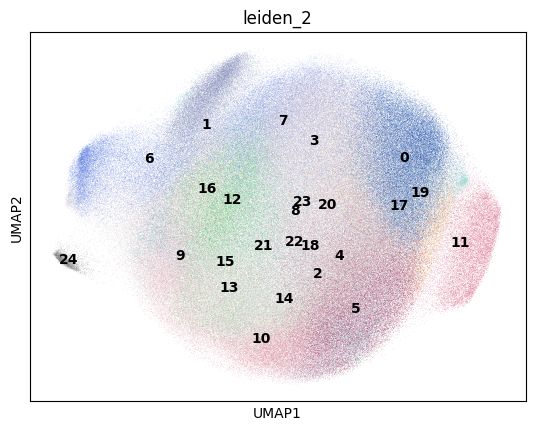

In [70]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

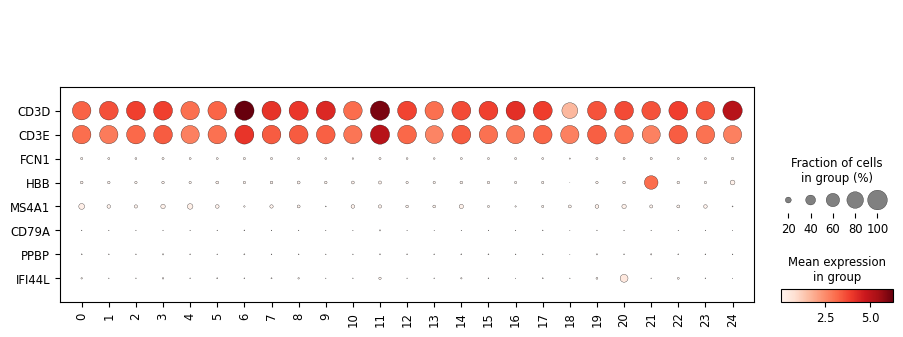

In [71]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

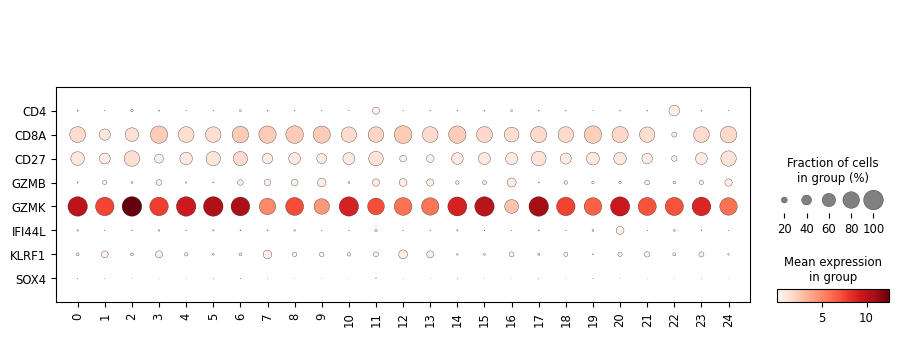

In [72]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [73]:
adata = add_labels(adata, original_df)

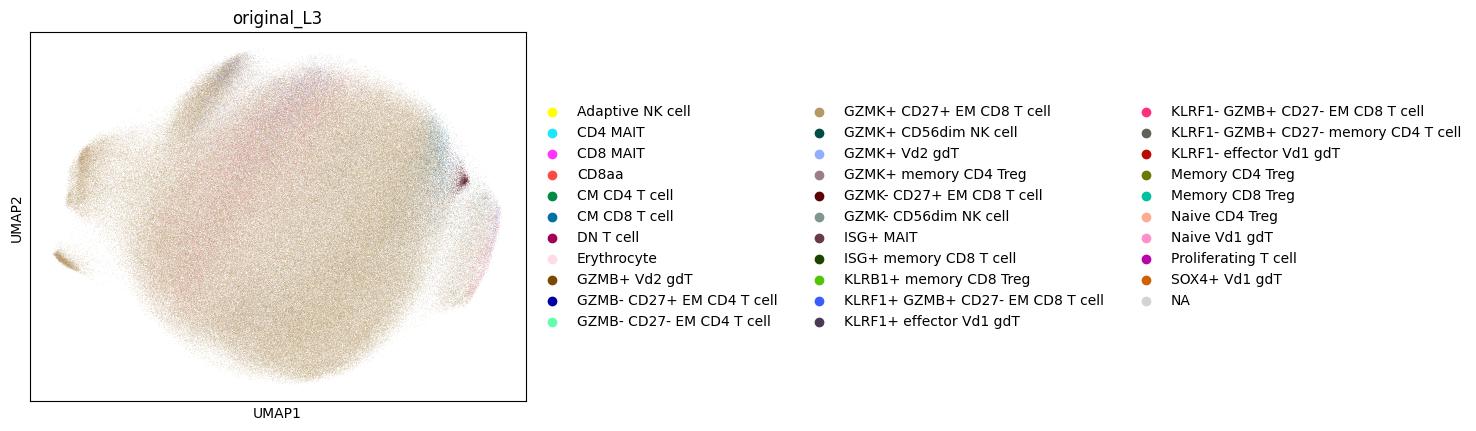

In [74]:
sc.pl.umap(adata, color = 'original_L3')

In [75]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
GZMK+ CD27+ EM CD8 T cell               484116
KLRF1- GZMB+ CD27- EM CD8 T cell         19847
NaN                                      18291
CM CD8 T cell                             8656
KLRF1+ GZMB+ CD27- EM CD8 T cell          7168
KLRF1- GZMB+ CD27- memory CD4 T cell      2917
GZMK- CD27+ EM CD8 T cell                 2710
GZMB- CD27+ EM CD4 T cell                 1633
CD8 MAIT                                   716
GZMK+ Vd2 gdT                              441
CD8aa                                      283
KLRB1+ memory CD8 Treg                     208
GZMB+ Vd2 gdT                              191
KLRF1+ effector Vd1 gdT                    190
Proliferating T cell                       125
ISG+ memory CD8 T cell                      38
CD4 MAIT                                    37
KLRF1- effector Vd1 gdT                     24
Erythrocyte                                 21
ISG+ MAIT                                   20
GZMB- CD27- EM CD4 T cell                   20
C

In [76]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
GZMK+ CD27+ EM CD8 T cell               0.883856
KLRF1- GZMB+ CD27- EM CD8 T cell        0.036235
NaN                                     0.033394
CM CD8 T cell                           0.015803
KLRF1+ GZMB+ CD27- EM CD8 T cell        0.013087
KLRF1- GZMB+ CD27- memory CD4 T cell    0.005326
GZMK- CD27+ EM CD8 T cell               0.004948
GZMB- CD27+ EM CD4 T cell               0.002981
CD8 MAIT                                0.001307
GZMK+ Vd2 gdT                           0.000805
CD8aa                                   0.000517
KLRB1+ memory CD8 Treg                  0.000380
GZMB+ Vd2 gdT                           0.000349
KLRF1+ effector Vd1 gdT                 0.000347
Proliferating T cell                    0.000228
ISG+ memory CD8 T cell                  0.000069
CD4 MAIT                                0.000068
KLRF1- effector Vd1 gdT                 0.000044
Erythrocyte                             0.000038
ISG+ MAIT                               0.000037
GZMB- CD

## Review ISG+ memory CD8 T cell

In [77]:
cell_type = 'ISG+ memory CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [78]:
type_uuid

'da959d88-251c-4475-9bfb-c90331598ae0'

In [79]:
adata = read_adata_uuid(type_uuid)

downloading fileID: da959d88-251c-4475-9bfb-c90331598ae0
Files have been successfully downloaded!


### Clustering

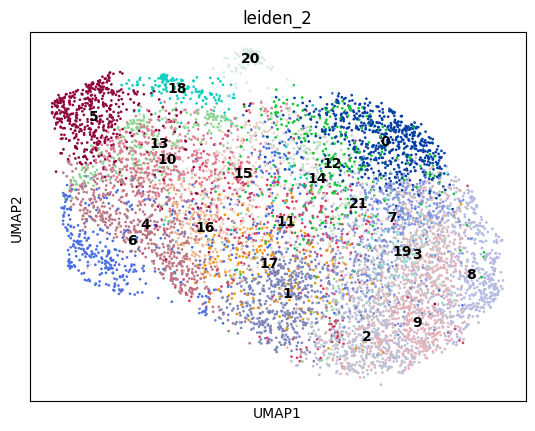

In [80]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

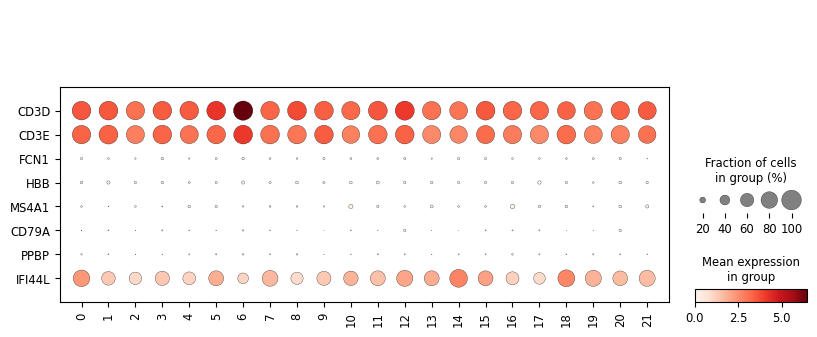

In [81]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

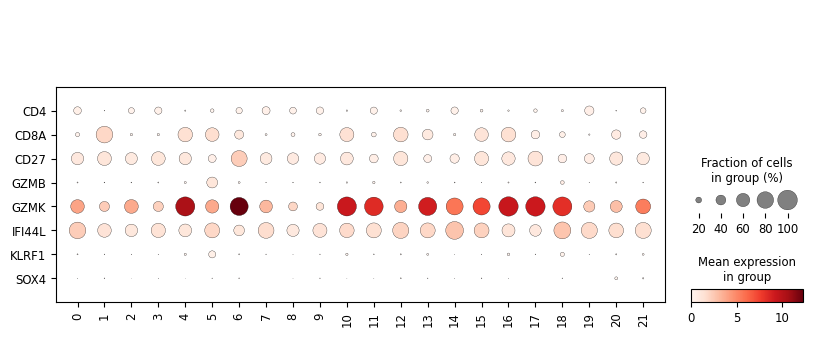

In [82]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [83]:
adata = add_labels(adata, original_df)

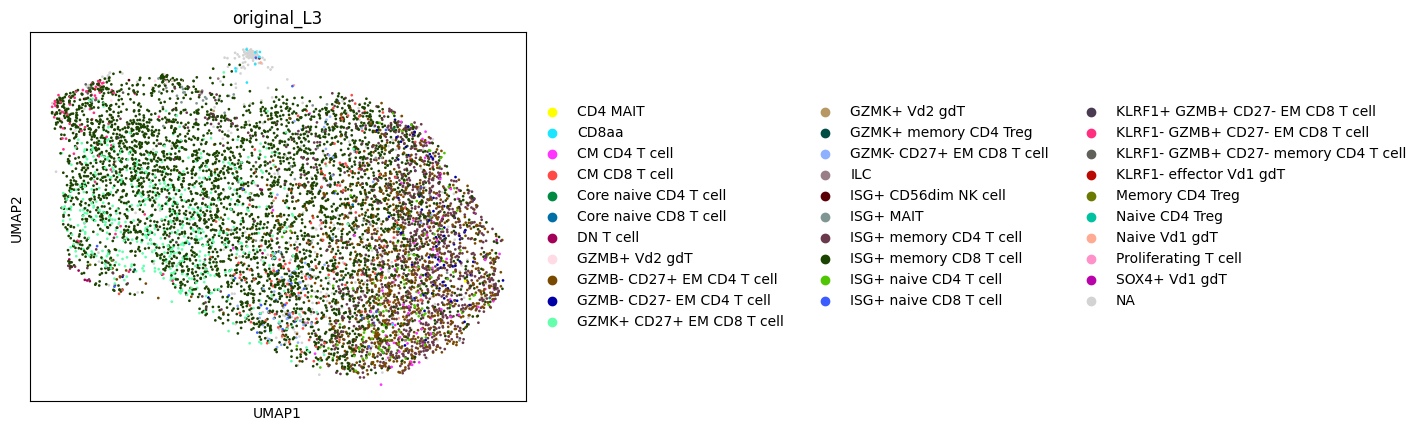

In [84]:
sc.pl.umap(adata, color = 'original_L3')

In [85]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
ISG+ memory CD8 T cell                  4093
ISG+ memory CD4 T cell                  1176
GZMB- CD27+ EM CD4 T cell                941
GZMK+ CD27+ EM CD8 T cell                559
NaN                                      425
CM CD8 T cell                            148
ISG+ naive CD4 T cell                    144
CM CD4 T cell                             96
GZMB- CD27- EM CD4 T cell                 79
KLRF1- GZMB+ CD27- EM CD8 T cell          76
GZMK- CD27+ EM CD8 T cell                 65
ISG+ MAIT                                 53
ISG+ naive CD8 T cell                     31
GZMB+ Vd2 gdT                             21
KLRF1- GZMB+ CD27- memory CD4 T cell      13
DN T cell                                  9
CD8aa                                      9
Memory CD4 Treg                            5
GZMK+ memory CD4 Treg                      5
Naive Vd1 gdT                              3
ISG+ CD56dim NK cell                       3
GZMK+ Vd2 gdT                              

In [86]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
ISG+ memory CD8 T cell                  0.513615
ISG+ memory CD4 T cell                  0.147572
GZMB- CD27+ EM CD4 T cell               0.118083
GZMK+ CD27+ EM CD8 T cell               0.070147
NaN                                     0.053332
CM CD8 T cell                           0.018572
ISG+ naive CD4 T cell                   0.018070
CM CD4 T cell                           0.012047
GZMB- CD27- EM CD4 T cell               0.009913
KLRF1- GZMB+ CD27- EM CD8 T cell        0.009537
GZMK- CD27+ EM CD8 T cell               0.008157
ISG+ MAIT                               0.006651
ISG+ naive CD8 T cell                   0.003890
GZMB+ Vd2 gdT                           0.002635
KLRF1- GZMB+ CD27- memory CD4 T cell    0.001631
DN T cell                               0.001129
CD8aa                                   0.001129
Memory CD4 Treg                         0.000627
GZMK+ memory CD4 Treg                   0.000627
Naive Vd1 gdT                           0.000376
ISG+ CD5

## Review ISG+ naive CD8 T cell

In [87]:
cell_type = 'ISG+ naive CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [88]:
type_uuid

'0f6c4cc7-c8d7-47ff-a58e-0851331f1ed3'

In [89]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 0f6c4cc7-c8d7-47ff-a58e-0851331f1ed3
Files have been successfully downloaded!


### Clustering

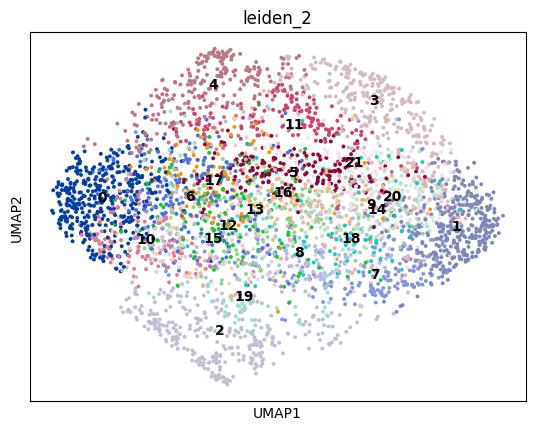

In [90]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

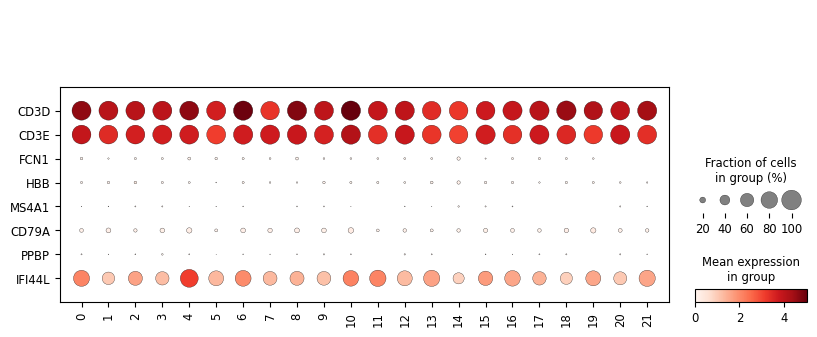

In [91]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

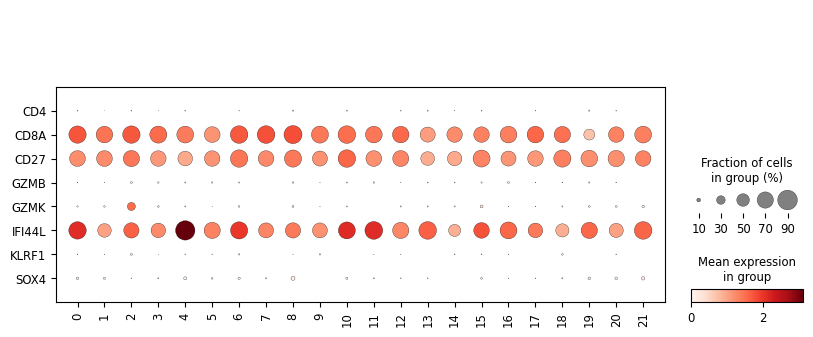

In [92]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [93]:
adata = add_labels(adata, original_df)

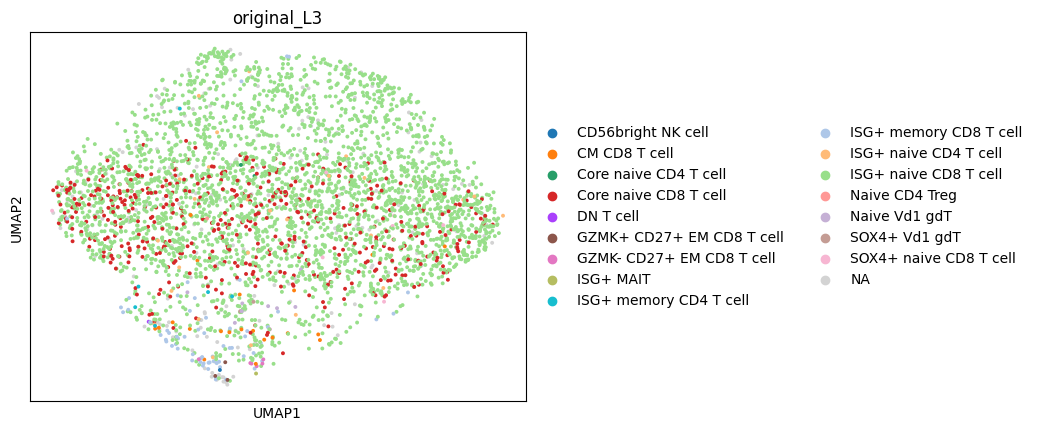

In [94]:
sc.pl.umap(adata, color = 'original_L3')

In [95]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
ISG+ naive CD8 T cell        2934
Core naive CD8 T cell         486
NaN                           228
ISG+ memory CD8 T cell         64
ISG+ naive CD4 T cell          27
CM CD8 T cell                  21
SOX4+ naive CD8 T cell          8
Naive Vd1 gdT                   8
GZMK- CD27+ EM CD8 T cell       7
ISG+ memory CD4 T cell          6
GZMK+ CD27+ EM CD8 T cell       3
SOX4+ Vd1 gdT                   2
Core naive CD4 T cell           2
ISG+ MAIT                       1
Naive CD4 Treg                  1
DN T cell                       1
CD56bright NK cell              1
Name: count, dtype: int64

In [96]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
ISG+ naive CD8 T cell        0.772105
Core naive CD8 T cell        0.127895
NaN                          0.060000
ISG+ memory CD8 T cell       0.016842
ISG+ naive CD4 T cell        0.007105
CM CD8 T cell                0.005526
SOX4+ naive CD8 T cell       0.002105
Naive Vd1 gdT                0.002105
GZMK- CD27+ EM CD8 T cell    0.001842
ISG+ memory CD4 T cell       0.001579
GZMK+ CD27+ EM CD8 T cell    0.000789
SOX4+ Vd1 gdT                0.000526
Core naive CD4 T cell        0.000526
ISG+ MAIT                    0.000263
Naive CD4 Treg               0.000263
DN T cell                    0.000263
CD56bright NK cell           0.000263
Name: count, dtype: float64

## Review KLRF1- GZMB+ CD27- EM CD8 T cell

In [97]:
cell_type = 'KLRF1- GZMB+ CD27- EM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [98]:
type_uuid

'134e3bd8-cad3-42e4-84d7-cf39704bc92a'

In [99]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 134e3bd8-cad3-42e4-84d7-cf39704bc92a
Files have been successfully downloaded!


### Clustering

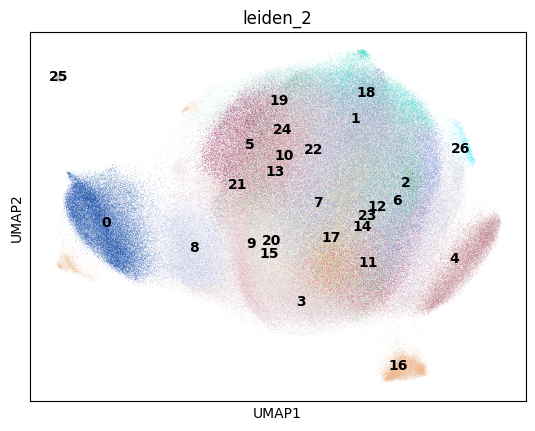

In [100]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

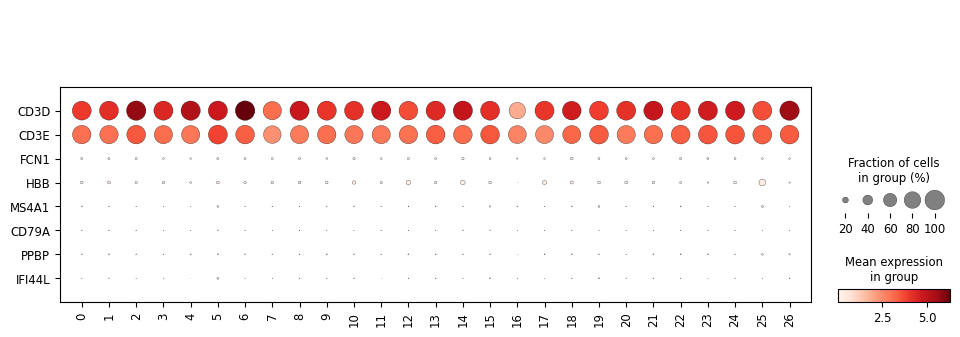

In [101]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

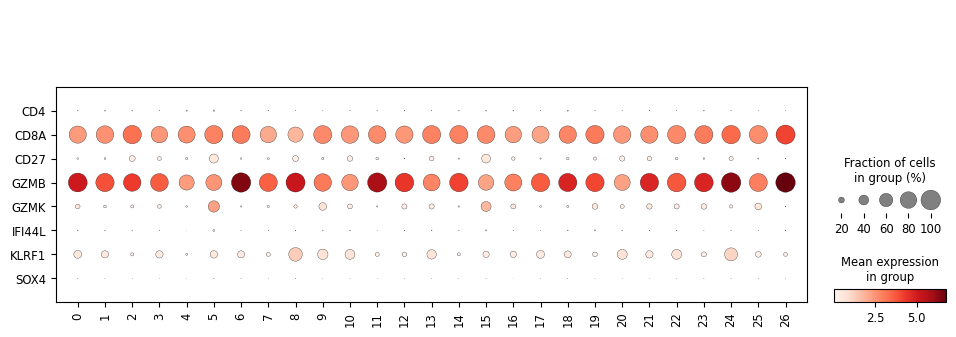

In [102]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [103]:
adata = add_labels(adata, original_df)

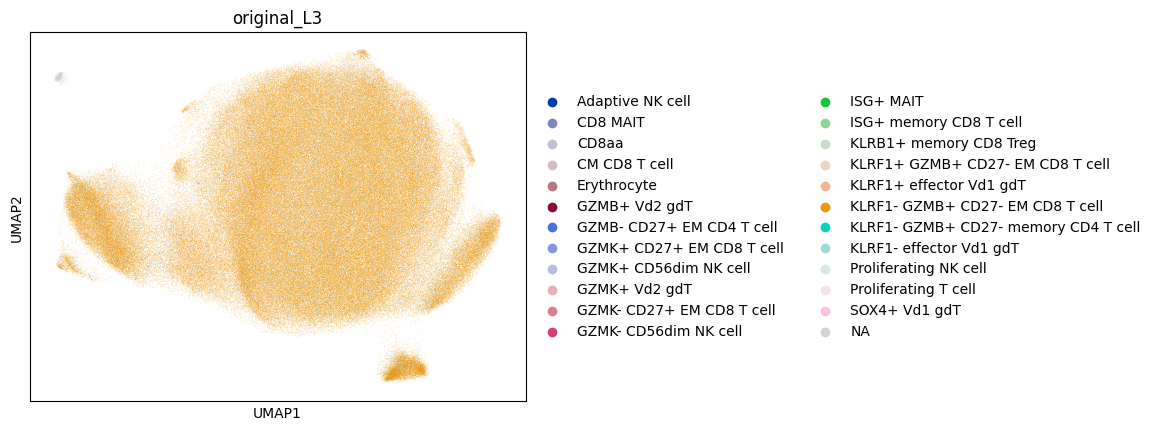

In [104]:
sc.pl.umap(adata, color = 'original_L3')

In [105]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
KLRF1- GZMB+ CD27- EM CD8 T cell        449539
NaN                                      16668
KLRF1+ GZMB+ CD27- EM CD8 T cell          6384
KLRF1- GZMB+ CD27- memory CD4 T cell      4907
GZMK+ CD27+ EM CD8 T cell                 1620
KLRF1- effector Vd1 gdT                   1402
Adaptive NK cell                          1010
KLRF1+ effector Vd1 gdT                    479
GZMB+ Vd2 gdT                              308
Proliferating T cell                        76
CD8aa                                       72
CM CD8 T cell                               35
GZMK- CD56dim NK cell                       23
KLRB1+ memory CD8 Treg                      22
GZMK- CD27+ EM CD8 T cell                   17
Erythrocyte                                 10
CD8 MAIT                                     6
GZMK+ CD56dim NK cell                        4
Proliferating NK cell                        3
GZMB- CD27+ EM CD4 T cell                    3
GZMK+ Vd2 gdT                                2
I

In [106]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
KLRF1- GZMB+ CD27- EM CD8 T cell        0.931506
NaN                                     0.034538
KLRF1+ GZMB+ CD27- EM CD8 T cell        0.013229
KLRF1- GZMB+ CD27- memory CD4 T cell    0.010168
GZMK+ CD27+ EM CD8 T cell               0.003357
KLRF1- effector Vd1 gdT                 0.002905
Adaptive NK cell                        0.002093
KLRF1+ effector Vd1 gdT                 0.000993
GZMB+ Vd2 gdT                           0.000638
Proliferating T cell                    0.000157
CD8aa                                   0.000149
CM CD8 T cell                           0.000073
GZMK- CD56dim NK cell                   0.000048
KLRB1+ memory CD8 Treg                  0.000046
GZMK- CD27+ EM CD8 T cell               0.000035
Erythrocyte                             0.000021
CD8 MAIT                                0.000012
GZMK+ CD56dim NK cell                   0.000008
Proliferating NK cell                   0.000006
GZMB- CD27+ EM CD4 T cell               0.000006
GZMK+ Vd

## Review KLRF1+ GZMB+ CD27- EM CD8 T cell

In [107]:
cell_type = 'KLRF1+ GZMB+ CD27- EM CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [108]:
type_uuid

'59cf63b1-99d4-4d8c-8d97-afa4b31928fa'

In [109]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 59cf63b1-99d4-4d8c-8d97-afa4b31928fa
Files have been successfully downloaded!


### Clustering

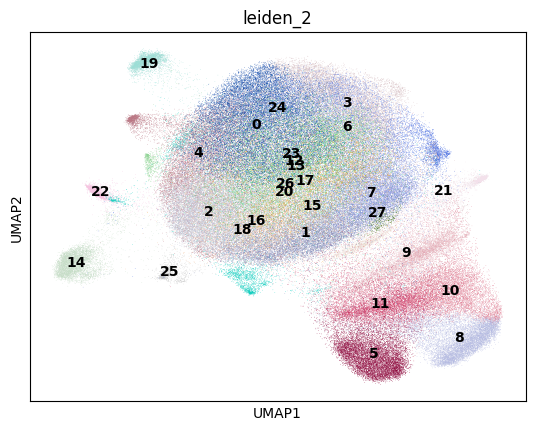

In [110]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

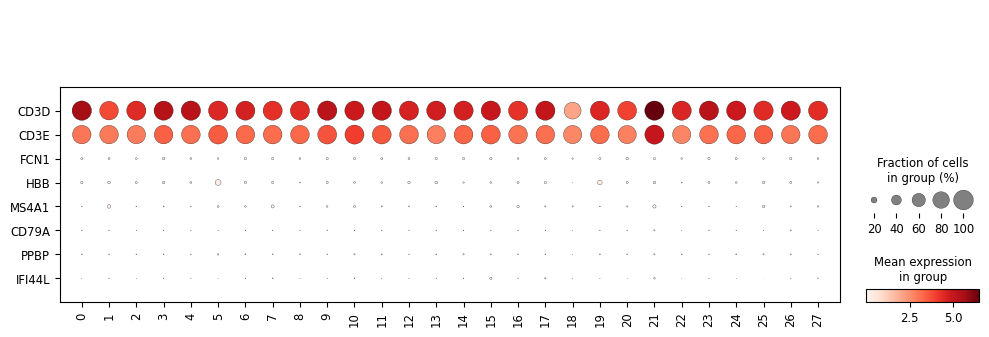

In [111]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

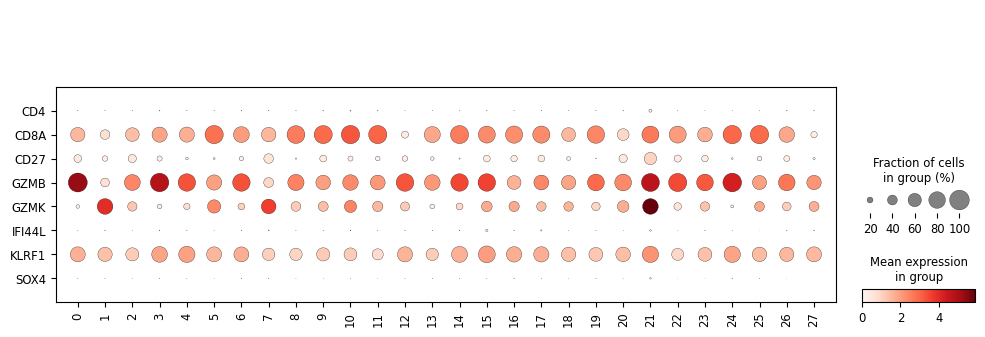

In [112]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Comparison to original labels

In [113]:
adata = add_labels(adata, original_df)

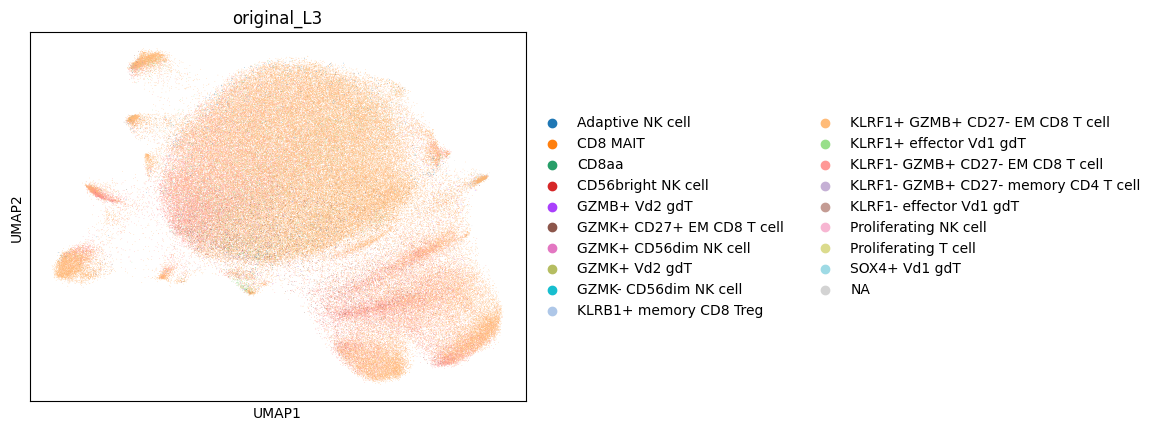

In [114]:
sc.pl.umap(adata, color = 'original_L3')

In [115]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
KLRF1+ GZMB+ CD27- EM CD8 T cell        130173
KLRF1- GZMB+ CD27- EM CD8 T cell         36046
KLRF1+ effector Vd1 gdT                   5192
GZMK+ CD27+ EM CD8 T cell                 3820
NaN                                       2053
Adaptive NK cell                           965
KLRF1- effector Vd1 gdT                    393
GZMB+ Vd2 gdT                              289
KLRF1- GZMB+ CD27- memory CD4 T cell        62
GZMK+ CD56dim NK cell                       59
CD8aa                                       54
Proliferating T cell                        25
GZMK+ Vd2 gdT                               24
GZMK- CD56dim NK cell                        6
CD56bright NK cell                           5
KLRB1+ memory CD8 Treg                       5
Proliferating NK cell                        3
CD8 MAIT                                     1
SOX4+ Vd1 gdT                                1
Name: count, dtype: int64

In [116]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
KLRF1+ GZMB+ CD27- EM CD8 T cell        0.726509
KLRF1- GZMB+ CD27- EM CD8 T cell        0.201176
KLRF1+ effector Vd1 gdT                 0.028977
GZMK+ CD27+ EM CD8 T cell               0.021320
NaN                                     0.011458
Adaptive NK cell                        0.005386
KLRF1- effector Vd1 gdT                 0.002193
GZMB+ Vd2 gdT                           0.001613
KLRF1- GZMB+ CD27- memory CD4 T cell    0.000346
GZMK+ CD56dim NK cell                   0.000329
CD8aa                                   0.000301
Proliferating T cell                    0.000140
GZMK+ Vd2 gdT                           0.000134
GZMK- CD56dim NK cell                   0.000033
CD56bright NK cell                      0.000028
KLRB1+ memory CD8 Treg                  0.000028
Proliferating NK cell                   0.000017
CD8 MAIT                                0.000006
SOX4+ Vd1 gdT                           0.000006
Name: count, dtype: float64

## Review SOX4+ naive CD8 T cell

In [117]:
cell_type = 'SOX4+ naive CD8 T cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [118]:
type_uuid

'39b49605-3b77-4599-83b4-d87633bc5f2b'

In [119]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 39b49605-3b77-4599-83b4-d87633bc5f2b
Files have been successfully downloaded!


### Clustering

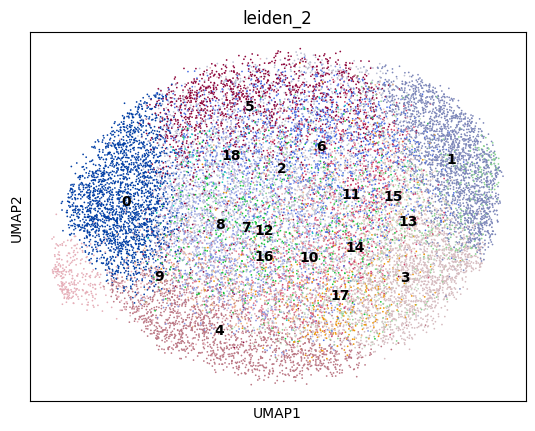

In [120]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

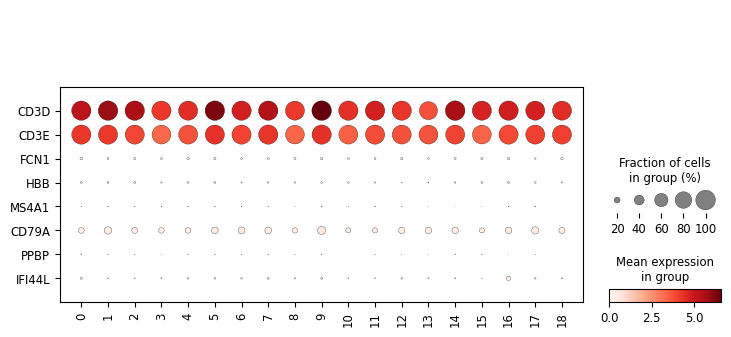

In [121]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

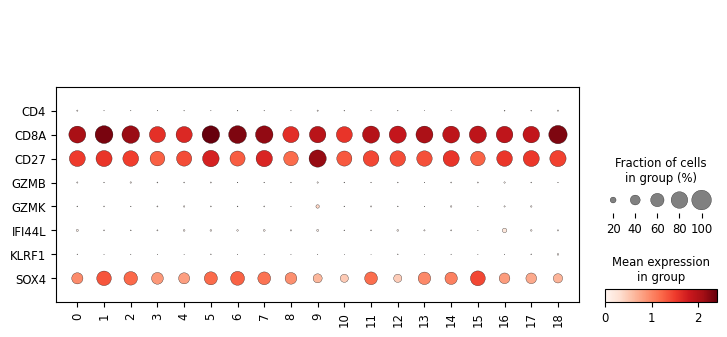

In [122]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

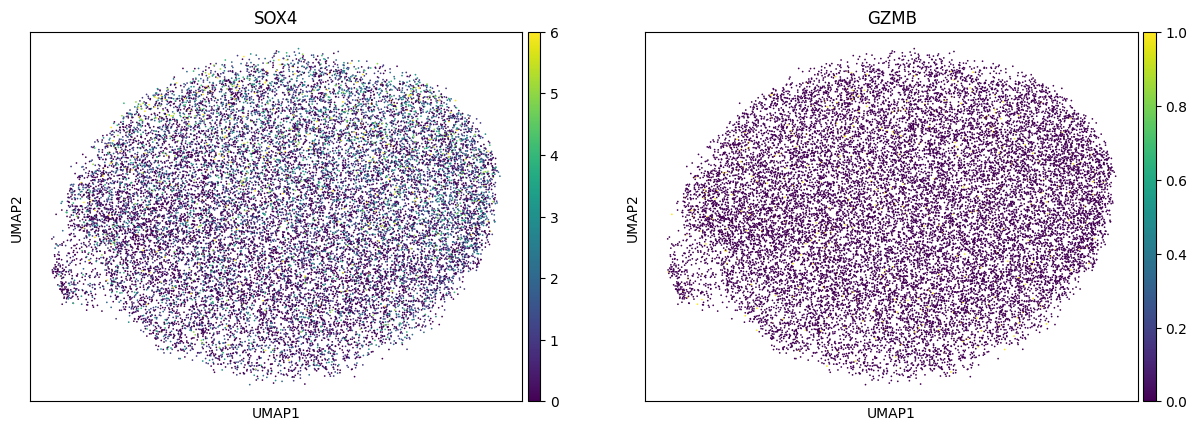

In [123]:
sc.pl.umap(adata, color = ['SOX4','GZMB'], vmax = 'p99')

### Cluster counts

In [124]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     2262
1     2176
2     1873
3     1843
4     1613
5     1438
6     1256
7     1140
8     1111
9      765
10     672
11     593
12     557
13     520
14     514
15     434
16     355
17     315
18      81
Name: count, dtype: int64

### Comparison to original labels

In [125]:
adata = add_labels(adata, original_df)

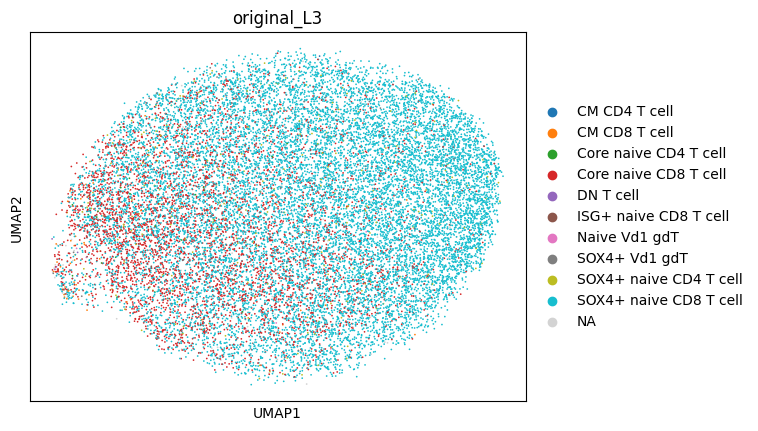

In [126]:
sc.pl.umap(adata, color = 'original_L3')

In [127]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
SOX4+ naive CD8 T cell    14804
Core naive CD8 T cell      4082
SOX4+ naive CD4 T cell      271
NaN                         221
CM CD8 T cell                53
SOX4+ Vd1 gdT                34
Core naive CD4 T cell        30
Naive Vd1 gdT                 9
ISG+ naive CD8 T cell         7
DN T cell                     6
CM CD4 T cell                 1
Name: count, dtype: int64

In [128]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
SOX4+ naive CD8 T cell    0.758479
Core naive CD8 T cell     0.209140
SOX4+ naive CD4 T cell    0.013885
NaN                       0.011323
CM CD8 T cell             0.002715
SOX4+ Vd1 gdT             0.001742
Core naive CD4 T cell     0.001537
Naive Vd1 gdT             0.000461
ISG+ naive CD8 T cell     0.000359
DN T cell                 0.000307
CM CD4 T cell             0.000051
Name: count, dtype: float64

In [129]:
os.system('jupyter nbconvert --to html --template pj 13c-Python_review_filtered_L3_cd8_t_cell_data.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook 13c-Python_review_filtered_L3_cd8_t_cell_data.ipynb to html
[NbConvertApp] Writing 15177287 bytes to 13c-Python_review_filtered_L3_cd8_t_cell_data.html


0

In [130]:
import session_info
session_info.show()